In [10]:
import math
import random
import time
import torch
import torch.optim as optim


from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from models import DQN, DuelingDQN, ReplayMemory, optimize_model

def select_action(state_in):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action_out = policy_net(state_in).max(1).indices.view(1, 1)
            return action_out
    else:
        return torch.tensor(spec.action_spec.random_action(1).discrete, device=device, dtype=torch.long)


In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

timer_start = time.perf_counter()
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 50_000
TAU = 0.005
LR = 1e-4

SAVE_WEIGHTS = True
LOAD_WEIGHTS = False
steps_done = 0
STEPS = 250
DOUBLE = False
DUELING = False
GRAPHICS = False

if torch.cuda.is_available():
    num_episodes = 5_000
else:
    num_episodes = 50


In [12]:

env = UnityEnvironment(file_name="unity_builds/snake", seed=1, side_channels=[], no_graphics=not GRAPHICS)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
# n_observations = len(state)
n_observations = spec.observation_specs[0].shape[0]

if DUELING:
    policy_net = DuelingDQN(n_observations, n_actions).to(device)
    target_net = DuelingDQN(n_observations, n_actions).to(device)
else:
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)

if LOAD_WEIGHTS:
    policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
    print("Loaded weights from file")

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)
print(f"Initalized DQN with {n_observations} observations and {n_actions} actions")
rewards = []
losses = []
lengths = []

Initalized DQN with 8 observations and 4 actions


In [13]:
pbar = tqdm(range(num_episodes))
for i_episode in pbar:
    if i_episode % 100 == 0 and i_episode != 0:
        print(
            f"Episode {i_episode}, avg reward: {np.mean(rewards[-100:]):.2f}, "
            f"epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.2f}")
        torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
        print("Checkpoint: Saved weights to file")
    step_rewards = []
    step_losses = []
    episode_length = []
    # Initialize the environment and get its state
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for t in range(STEPS):
        # time.sleep(1)
        action = select_action(state)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        assert action.shape[0] == state.shape[0]

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        reward = np.zeros(state.shape[0])
        if len(decision_steps.reward) > 0:
            reward += decision_steps.reward
        if len(terminal_steps.reward) > 0:
            reward += terminal_steps.reward
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0
        # print(observation, reward, done, terminated, action)
        assert len(reward) == state.shape[0] == action.shape[0]

        # if t % 50 == 0:
        #     print(f"step: {t}, reward: {reward}, state: {state}, action: {action}")
        reward = torch.tensor(reward, device=device)
        step_rewards.append(reward.item())


        if done or terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model(memory, policy_net, target_net, optimizer, device, double=DOUBLE, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA)
        if loss is not None:
            step_losses.append(loss)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if terminated or done:
            episode_length.append(t)
            break
    
    if len(step_losses) == 0:
        step_losses.append(0)
    losses.append(np.mean(step_losses))
    lengths.append(np.mean(episode_length))
    ep_rewards = sum(step_rewards)
    pbar.set_description(f"E {i_episode} done after {t + 1} t, with r: {ep_rewards:.2f} and l: {np.mean(step_losses):.2f}")
    rewards.append(ep_rewards)

env.close()
print(f"Finished training in {(time.perf_counter() - timer_start)/60 :.3} minutes")


E 100 done after 2 t, with r: -1.20 and l: 0.01:   2%|▏         | 100/5000 [02:10<2:02:38,  1.50s/it]

Episode 100, avg reward: 0.12, epsilon: 0.80
Checkpoint: Saved weights to file


E 199 done after 67 t, with r: 1.30 and l: 0.01:   4%|▍         | 200/5000 [04:00<1:27:26,  1.09s/it]  

Episode 200, avg reward: 0.60, epsilon: 0.73
Checkpoint: Saved weights to file


E 299 done after 3 t, with r: -1.10 and l: 0.01:   6%|▌         | 299/5000 [05:31<57:02,  1.37it/s]   

Episode 300, avg reward: 0.80, epsilon: 0.68
Checkpoint: Saved weights to file


E 399 done after 22 t, with r: 1.20 and l: 0.01:   8%|▊         | 400/5000 [06:41<44:58,  1.70it/s]   

Episode 400, avg reward: 0.70, epsilon: 0.64
Checkpoint: Saved weights to file


E 499 done after 13 t, with r: 0.50 and l: 0.01:  10%|█         | 500/5000 [07:49<28:02,  2.68it/s]   

Episode 500, avg reward: 0.93, epsilon: 0.61
Checkpoint: Saved weights to file


E 600 done after 9 t, with r: 0.30 and l: 0.00:  12%|█▏        | 600/5000 [08:51<48:56,  1.50it/s]   

Episode 600, avg reward: 1.06, epsilon: 0.58
Checkpoint: Saved weights to file


E 699 done after 34 t, with r: 2.60 and l: 0.00:  14%|█▍        | 700/5000 [10:02<47:36,  1.51it/s]  

Episode 700, avg reward: 1.25, epsilon: 0.54
Checkpoint: Saved weights to file


E 799 done after 19 t, with r: 1.30 and l: 0.00:  16%|█▌        | 800/5000 [11:04<33:10,  2.11it/s]   

Episode 800, avg reward: 1.22, epsilon: 0.52
Checkpoint: Saved weights to file


E 899 done after 48 t, with r: 1.20 and l: 0.01:  18%|█▊        | 900/5000 [12:05<1:02:01,  1.10it/s]

Episode 900, avg reward: 1.42, epsilon: 0.49
Checkpoint: Saved weights to file


E 999 done after 9 t, with r: 0.70 and l: 0.01:  20%|██        | 1000/5000 [13:03<30:41,  2.17it/s]  

Episode 1000, avg reward: 1.37, epsilon: 0.47
Checkpoint: Saved weights to file


E 1099 done after 30 t, with r: 1.20 and l: 0.01:  22%|██▏       | 1100/5000 [13:55<29:47,  2.18it/s] 

Episode 1100, avg reward: 1.06, epsilon: 0.45
Checkpoint: Saved weights to file


E 1199 done after 31 t, with r: 1.50 and l: 0.00:  24%|██▍       | 1200/5000 [14:50<33:44,  1.88it/s]  

Episode 1200, avg reward: 1.41, epsilon: 0.44
Checkpoint: Saved weights to file


E 1299 done after 28 t, with r: 2.40 and l: 0.01:  26%|██▌       | 1300/5000 [15:48<39:58,  1.54it/s] 

Episode 1300, avg reward: 1.72, epsilon: 0.42
Checkpoint: Saved weights to file


E 1399 done after 31 t, with r: 2.50 and l: 0.01:  28%|██▊       | 1400/5000 [16:44<33:35,  1.79it/s] 

Episode 1400, avg reward: 1.64, epsilon: 0.40
Checkpoint: Saved weights to file


E 1499 done after 10 t, with r: 0.60 and l: 0.01:  30%|███       | 1500/5000 [17:39<25:39,  2.27it/s] 

Episode 1500, avg reward: 1.71, epsilon: 0.39
Checkpoint: Saved weights to file


E 1599 done after 44 t, with r: 2.00 and l: 0.01:  32%|███▏      | 1600/5000 [18:36<36:59,  1.53it/s] 

Episode 1600, avg reward: 1.84, epsilon: 0.37
Checkpoint: Saved weights to file


E 1699 done after 1 t, with r: -1.10 and l: 0.02:  34%|███▍      | 1699/5000 [19:36<22:27,  2.45it/s]

Episode 1700, avg reward: 2.24, epsilon: 0.36
Checkpoint: Saved weights to file


E 1799 done after 37 t, with r: 1.90 and l: 0.01:  36%|███▌      | 1800/5000 [20:36<28:45,  1.85it/s] 

Episode 1800, avg reward: 2.06, epsilon: 0.34
Checkpoint: Saved weights to file


E 1899 done after 24 t, with r: 1.40 and l: 0.01:  38%|███▊      | 1900/5000 [21:28<25:31,  2.02it/s]

Episode 1900, avg reward: 2.02, epsilon: 0.33
Checkpoint: Saved weights to file


E 1999 done after 69 t, with r: 4.70 and l: 0.01:  40%|████      | 2000/5000 [22:30<41:19,  1.21it/s]

Episode 2000, avg reward: 2.45, epsilon: 0.32
Checkpoint: Saved weights to file


E 2099 done after 16 t, with r: 1.80 and l: 0.01:  42%|████▏     | 2100/5000 [23:34<22:41,  2.13it/s]   

Episode 2100, avg reward: 2.64, epsilon: 0.30
Checkpoint: Saved weights to file


E 2199 done after 22 t, with r: 1.00 and l: 0.01:  44%|████▍     | 2200/5000 [24:31<29:11,  1.60it/s]  

Episode 2200, avg reward: 2.36, epsilon: 0.29
Checkpoint: Saved weights to file


E 2300 done after 9 t, with r: 0.50 and l: 0.01:  46%|████▌     | 2300/5000 [25:37<35:48,  1.26it/s]   

Episode 2300, avg reward: 3.03, epsilon: 0.28
Checkpoint: Saved weights to file


E 2400 done after 9 t, with r: -0.50 and l: 0.01:  48%|████▊     | 2400/5000 [26:39<19:25,  2.23it/s] 

Episode 2400, avg reward: 2.80, epsilon: 0.27
Checkpoint: Saved weights to file


E 2499 done after 37 t, with r: 1.90 and l: 0.01:  50%|█████     | 2500/5000 [27:37<27:28,  1.52it/s] 

Episode 2500, avg reward: 2.77, epsilon: 0.26
Checkpoint: Saved weights to file


E 2599 done after 34 t, with r: 4.60 and l: 0.01:  52%|█████▏    | 2600/5000 [28:43<22:34,  1.77it/s]  

Episode 2600, avg reward: 3.42, epsilon: 0.25
Checkpoint: Saved weights to file


E 2699 done after 9 t, with r: 0.50 and l: 0.01:  54%|█████▍    | 2700/5000 [29:45<19:57,  1.92it/s]  

Episode 2700, avg reward: 3.50, epsilon: 0.24
Checkpoint: Saved weights to file


E 2799 done after 46 t, with r: 5.00 and l: 0.02:  56%|█████▌    | 2800/5000 [30:49<28:10,  1.30it/s] 

Episode 2800, avg reward: 3.38, epsilon: 0.23
Checkpoint: Saved weights to file


E 2899 done after 12 t, with r: 0.80 and l: 0.01:  58%|█████▊    | 2900/5000 [31:49<11:53,  2.94it/s] 

Episode 2900, avg reward: 3.30, epsilon: 0.23
Checkpoint: Saved weights to file


E 2999 done after 50 t, with r: 8.40 and l: 0.01:  60%|██████    | 3000/5000 [32:49<23:01,  1.45it/s] 

Episode 3000, avg reward: 3.33, epsilon: 0.22
Checkpoint: Saved weights to file


E 3099 done after 22 t, with r: 2.60 and l: 0.01:  62%|██████▏   | 3100/5000 [33:57<17:37,  1.80it/s]  

Episode 3100, avg reward: 3.84, epsilon: 0.21
Checkpoint: Saved weights to file


E 3199 done after 33 t, with r: 1.90 and l: 0.01:  64%|██████▍   | 3200/5000 [35:05<21:38,  1.39it/s]  

Episode 3200, avg reward: 3.97, epsilon: 0.20
Checkpoint: Saved weights to file


E 3299 done after 62 t, with r: 5.60 and l: 0.01:  66%|██████▌   | 3300/5000 [36:07<21:37,  1.31it/s] 

Episode 3300, avg reward: 3.83, epsilon: 0.20
Checkpoint: Saved weights to file


E 3399 done after 18 t, with r: 3.40 and l: 0.01:  68%|██████▊   | 3400/5000 [37:14<13:37,  1.96it/s]  

Episode 3400, avg reward: 3.93, epsilon: 0.19
Checkpoint: Saved weights to file


E 3478 done after 37 t, with r: 4.90 and l: 0.01:  70%|██████▉   | 3479/5000 [38:10<18:28,  1.37it/s]  

In [9]:

if SAVE_WEIGHTS:
    torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
    rewards_df = pd.DataFrame(rewards, columns=['reward'])
    rewards_df.to_csv('rewards.csv', index=False)
    losses_df = pd.DataFrame(losses, columns=['loss'])
    losses_df.to_csv('losses.csv', index=False)
    lengths_df = pd.DataFrame(lengths, columns=['length'])
    lengths_df.to_csv('lengths.csv', index=False)
    print("Saved weights and data to file")

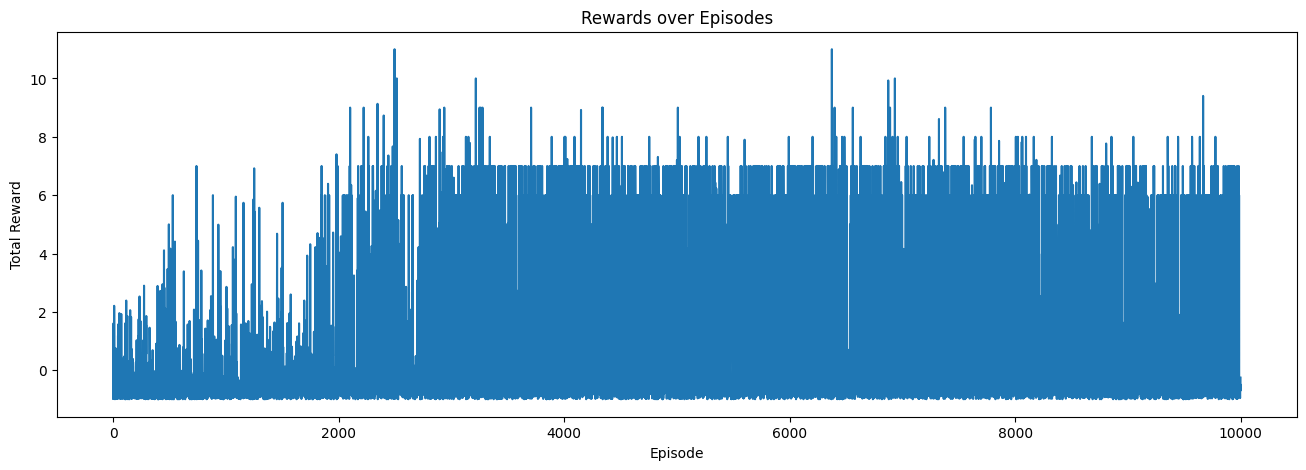

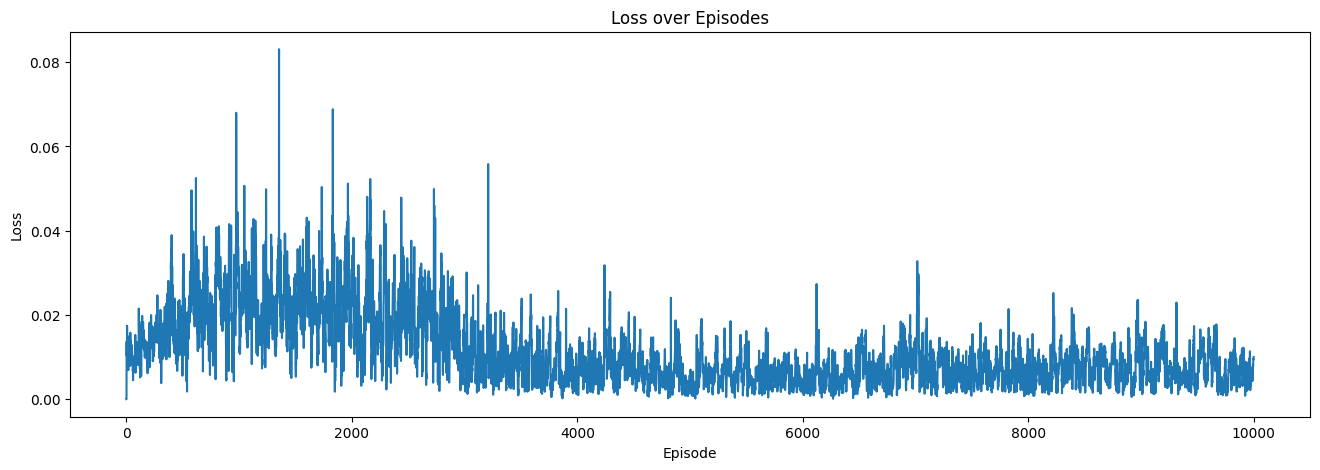

In [5]:

plt.figure(figsize=(16, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(lengths)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Length over Episodes')
plt.show()


Inference

In [8]:
env = UnityEnvironment(file_name="unity_builds/snake", seed=3, side_channels=[], no_graphics=False)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
# n_observations = len(state)
n_observations = spec.observation_specs[0].shape[0]

# policy_net = DQN(n_observations, n_actions).to(device)
# policy_net = DuelingDQN(n_observations, n_actions).to(device)
# policy_net.load_state_dict(torch.load('weights/large_observations/4k/policy_net.pth'))
# policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
for t in range(5):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for i in range(100):
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
    
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0

        if done or terminated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device)
env.close()